# Введение в Data Science и машинное обучение

Анатолий Карпов / Bioinformatics Institute

https://stepik.org/course/4852/

## 1. Введение

## Stepik ML contest

### 1.10. Stepik ML contest - это еще что такое?

Практическим проектом нашего курса будет анализ активности студентов онлайн курса [Введение в анализ данных в R](https://stepik.org/course/129/syllabus), спасибо команде stepik, что предоставили анонимизированные данные.

В этом модуле, мы разберемся с задачей, начнем исследовать данные, а об условиях соревнований, призах и тайных стэпах раскажу во втором модуле!

Описание данных:

[events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами

1. `step_id` - id стэпа
2. `user_id` - анонимизированный id юзера
3. `timestamp` - время наступления события в формате unix date
4. `action` - событие, возможные значения: 
    - `discovered` - пользователь перешел на стэп
    - `viewed` - просмотр шага,
    - `started_attemp`t - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    - `passed` - удачное решение практического шага


[submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям

1. `step_id` - id стэпа
2. `timestamp` - время отправки решения в формате unix date
3. `submission_status` - статус решения
4. `user_id` - анонимизированный id юзера

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')

events_data = pd.read_csv('_wrk\\data\\event_data_train.zip', compression='zip')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


`action` - событие, возможные значения

In [4]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

перевод `timestamp` в удобоваримый формат даты

In [5]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [6]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [7]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [8]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [9]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

добавление отдельной колонки с днём

In [10]:
events_data['day'] = events_data.date.dt.date

In [11]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


график активности студентов за всё это время - количество уникальных пользователей ежедневно

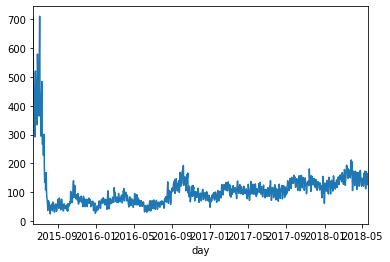

In [12]:
events_data.groupby('day').user_id.nunique().plot()

Чтобы избежать наложения значений, отмеченных на оси x, друг на друга можно задать параметры `figsize` именно для этого графика...

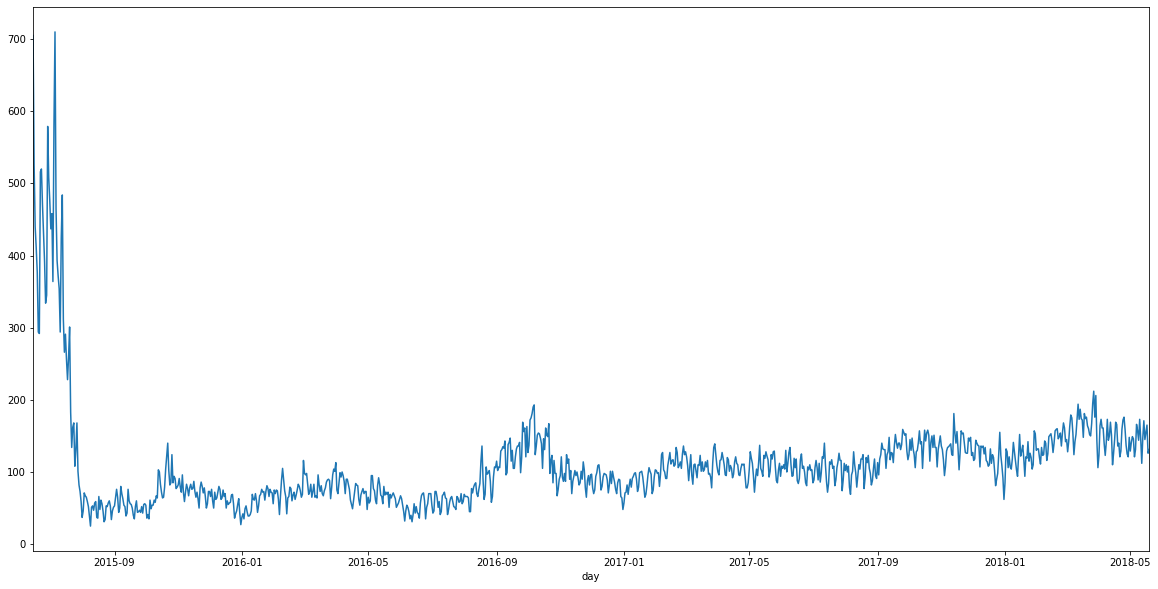

In [13]:
events_data.groupby('day').user_id.nunique().plot(figsize=(20,10))

...или изменить настройки seaborn (для **всех** последующих графиков)

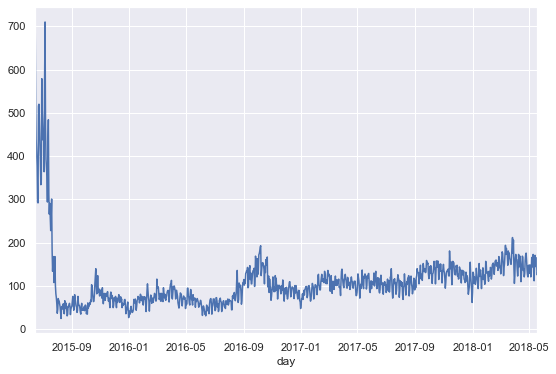

In [14]:
sns.set(rc={'figure.figsize': (9, 6)})
events_data.groupby('day').user_id.nunique().plot()

для каждого пользователя (без учёта даты начала его работы с курсом) посчитаем число пройденных степов и построим распределение

#### !Внимание! НЕПРАВИЛЬНОЕ решение

Отберём все события, у которых action = passed, далее сгруппируем их по пользователю и посчитаем число степов с событие passed.

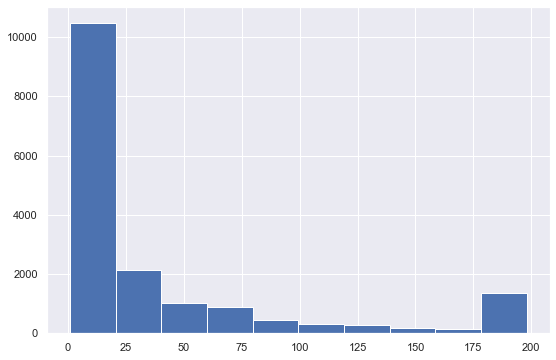

In [15]:
events_data[events_data.action == 'passed']\
    .groupby('user_id', as_index=False)\
    .agg({'step_id': 'count'})\
    .rename(columns={'step_id': 'passed_steps'})\
    .passed_steps.hist()

#### ПРАВИЛЬНОЕ решение

на каждом аналитическом этапе необходимо постоянно себя валидировать - не потерялись ли какие-либо данные (если бы мы сравнили число уникальных пользователей ДО и ПОСЛЕ группировки, то поняли бы, что потеряли данные)

In [16]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


после применения pivot таблицы зачастую удобно сделать сброс индекса - для исключения сложных составных индексов

In [17]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


было бы достаточно удобно взять для каждого юзера колонку discovered и построить по ней гистограмму

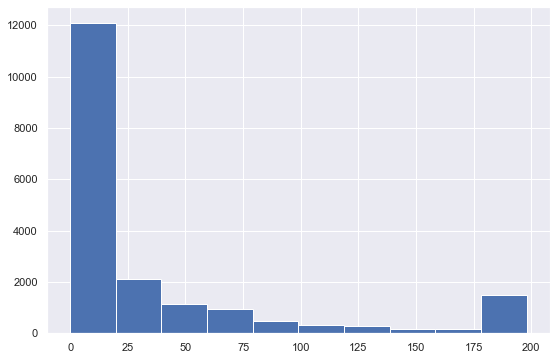

In [18]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

**теперь в первом столбце мы также учли пользователей, которых потеряли в первом (неправильном) решении**